# Single-cell profiling identifies ACE+ granuloma macrophages as a non-permissive niche for intracellular bacteria during persistent Salmonella infection 

## Background

This is a jupyter notebook for the manuscript: \
**Single-cell profiling identifies ACE+ granuloma macrophages as a non-permissive niche for intracellular bacteria during persistent Salmonella infection (2022). Trung H. M. Pham†‡, Yuan Xue†, Susan M. Brewer, Kenneth E. Bernstein, Stephen R. Quake‡, Denise Monack‡. [bioRxiv preprint](https://www.biorxiv.org/content/10.1101/2022.07.21.501041v1.full.pdf+html).**

Legends:
†: co-first authors.
‡: co-corresponding authors.

In this study, we isolated immune cells from mice spleens and profiled their single-cell transcriptomics during persistent infection by an intracellular bacteria, *Salmonella typhimurium*. We identified a novel ACE$^+$ macrophage cell type that emerges as a non-persistent niche of the *Salmonella* bacteria during the course of infection. In an effort to improve study reproducibility, we will walk through the different datasets that we generated and show how to reproduce some of the analysis results.

## Accessing code and data to reproduce analysis of this notebook

Github repository associated with this notebook:

[https://github.com/xuesoso/2022_ACE_Granuloma_Macrophage](https://github.com/xuesoso/2022_ACE_Granuloma_Macrophage)

1. You can clone this repository to your local computer with:

    `
    git clone https://github.com/xuesoso/2022_ACE_Granuloma_Macrophage
    `
    

2. In `README.md`, you will find instructions on how to access the raw and processed data, and analysis code used in this notebook.


3. To follow the notebook, the fastest way to access the processed data is through the [shared Google Drive](https://drive.google.com/drive/folders/1ohx-A5gmWS42yG77ee6h7KLyaY4CINQV?usp=share_link) or [Dryad deposit](https://datadryad.org/stash/dataset/doi:10.5061%2Fdryad.ksn02v77w). Download `data.zip` and unzip the contents to the data directory inside this repository:
    
    `
    cd 2022_ACE_Granuloma_Macrophage/
    `
    
    `
    unzip data.zip -d ./data/
    `

## Installing the dependencies to run this notebook

**Two options to build the packages required by the code in this notebook**:

1. The easiest way is to build the Docker image with the Dockerfile provided in this repository and run the Jupyter notebook inside a container.
    - Required: [Install Docker](https://docs.docker.com/get-docker/)

    Once you have Docker installed, navigate to the local directory of this Github repository:

    `
    cd 2022_ACE_Granuloma_Macrophage/
    `

    Execute the script to build the image with pre-specified configurations:

    `
    bash ./Docker/build_docker.sh
    `

    Execute the script to run this notebook under the Docker container:

    `
    bash ./Docker/run_docker.sh
    `

    Navigate to the local address of the Jupyter notebook on your favorite browser, the default port passed is set to `8887`:

    `
    firefox http://localhost:8887/notebooks/notebook/analysis_notebook.ipynb
    `
    

2. The second approach is to manually install the exact library versions. **This is not recommended as it involves navigating a complicated dependency graph**:
    - Install [Anaconda v4.8.3 with python 3.8](https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.3-Linux-x86_64.sh) on Linux system (tested on Ubuntu 18.04/Fedora 36).
    - Execute in shell: `conda install -c conda-forge install python=3.7.0`
    - Install the exact version of python packages with `pip` as documented in `requirements.txt`
    - Note: You may have to install different dependent packages than the latest versions recommended by your platform's package manager.

## Load dependent libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.insert(0, '../')
from src.python.variables.granuloma_lib import *
import visualization.plot as pl
import src.python.scripts.analysis as analysis
plt.style.use('default')

Check and make sure we have all processed input data

In [2]:
ls $infd

201221_10X_velocyto_all.h5ad
ABCT_SAM_momac.220828_review.h5ad
harmony.sam_T_C_treatment.200119.sam_full.210505.h5ad
sam_full.210505.h5ad
sam_full_velocyto.210505.h5ad
sam_macrophageSubset_AB.210919.h5ad
sam_monocyteSubset.210505.h5ad
sam_monocyte_velocyto.210505.h5ad
sam_myeloidSubset.210505.h5ad


## Load scRNA-seq data of all immune cells from WT (A) + $\Delta$*STeE* (B) STm infected mice

### Figure 1A: UMAP of immune cell population showing cell type annotations

In [3]:
fn = infd+'sam_full.210505.h5ad'
adh = sc.read_h5ad(fn)

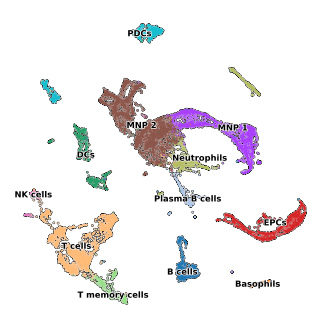

In [4]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(adh, color='label', legend_loc='on data', legend_fontsize=6,
        s=5, frameon=False, ax=ax, title='', legend_fontoutline=1, add_outline=True)
sfig(fig, fdm+'1A.umap_full_ann_outline')

### SFigure 1D: Quality metrics of scRNA-seq library

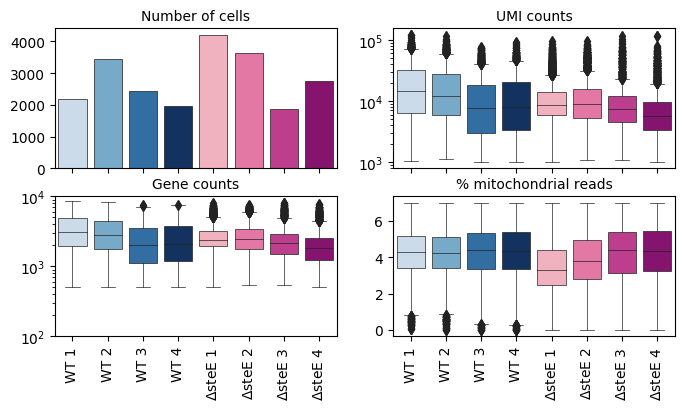

In [5]:
#### SFig1 - quality check metrics
qcmetrics = ['read_sum', 'gene_counts', 'pct_counts_mt']

dtcmap = {dt[x]:cmap[x] for x in set(adh.obs['treatment'].values)}
adh.obs['batch_label'] = [dt[x[0]]+' '+x[1] for x in adh.obs['batch']]
order = [dt[x[0]] + ' ' + x[1] for x in sorted(set(adh.obs['batch']))]
top = mpl.cm.get_cmap('Blues', 128)
bottom = mpl.cm.get_cmap('RdPu', 128)
newcolors = np.vstack((top(np.linspace(0.25, 1, 4)), bottom(np.linspace(0.35, 0.8, 4))))
tmp = adh.obs.groupby('batch_label').count().reset_index()
fs = 10

fig, axs = plt.subplots(figsize=(8, 4), ncols=2, nrows=2, sharex=True)
axs = axs.flatten()
sns.barplot(data=tmp, ax=axs[0], x='batch_label', y='batch', order=order,
        palette=newcolors, linewidth=0.5, edgecolor='k')
sns.boxplot(data=adh.obs, ax=axs[1], x='batch_label', y='read_sum',
        linewidth=0.5, order=order, palette=newcolors)
sns.boxplot(data=adh.obs, ax=axs[2], x='batch_label', y='gene_counts',
        linewidth=0.5, order=order, palette=newcolors)
sns.boxplot(data=adh.obs, ax=axs[3], x='batch_label', y='pct_counts_mt',
        linewidth=0.5, order=order, palette=newcolors)
axs[1].set_yscale('log');
axs[2].set_yscale('log');
axs[1].set_yticks([1e3, 1e4, 1e5]);
axs[2].set_yticks([1e2, 1e3, 1e4]);
axs[0].set_title('Number of cells', fontsize=fs)
axs[1].set_title('UMI counts', fontsize=fs)
axs[2].set_title('Gene counts', fontsize=fs)
axs[3].set_title('% mitochondrial reads', fontsize=fs)
for ax in axs:
    ax.tick_params(axis='x', rotation=90, labelsize=fs)
    ax.tick_params(axis='y', labelsize=fs)
    ax.set_xlabel('');
    ax.set_ylabel('');
sfig(fig, fdm+'s1A.boxplot_gc_rs_mt_pct')

### Figure 1B: Boxplot of cell type frequency

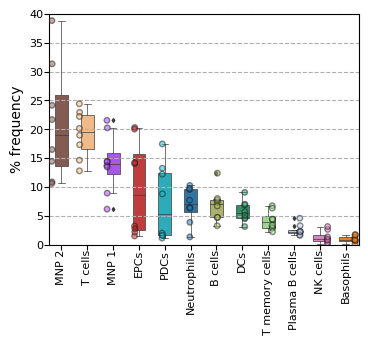

In [6]:
groups_order = ['PDCs', 'B cells', 'NK cells', 'T memory cells', 'EPCs',
        'Plasma B cells', 'T cells', 'Basophils', 'Neutrophils', 'MNP 1', 'DCs', 'MNP 2']
_cta_ = 'label'
obs = adh.obs[[_cta_, 'batch']].copy()
dtcmap = {dt[x]:cmap[x] for x in cmap}
df_abundance = obs.groupby([_cta_, 'batch']).size().unstack().fillna(0)
df_abundance = df_abundance.loc[groups_order]
Dpivot = df_abundance.div(df_abundance.sum(axis=0), axis=1)*100
Dpivot.columns = [dt[x[0]]+' '+x[1] for x in Dpivot.columns]
D = Dpivot.stack().reset_index()
D.columns = ['cluster', 'group', 'frequency']
D['group'] = [x.split(' ')[0] for x in D['group']]
hue_order = list(dt.values())
order = D.groupby('cluster')['frequency'].mean().sort_values()[::-1].index

df_sum = df_abundance.sum(1).sort_values()[::-1]
df_fraction = df_sum / df_sum.sum() * 100
_cmap_ = {y:'{:}'.format(adh.uns['label_colors'][x]) for x, y in enumerate(np.unique(adh.obs['label']))}
c = [_cmap_[x] for x in df_sum.index]

fig, ax = plt.subplots(figsize=(4, 3))
gfg = sns.boxplot(data=D, x='cluster', y='frequency', ax=ax, width=0.5,
        linewidth=0.5, fliersize=2, orient='v', order=order, palette=c)
ax = sns.stripplot(x="cluster", y="frequency", data=D, edgecolor='k',
        linewidth=1, alpha=0.5, ax=ax, jitter=True, palette=c,
        dodge=True, marker='o', size=4, order=order)
ax.set_xlabel(''); ax.set_ylabel('% frequency', fontsize=10);
ax.set_ylim(0, 40)
gfg.tick_params(labelsize=8, top=False, pad=0)
ax.set_xticklabels(ax.get_xticklabels(), minor=False, rotation=90);
ax.grid(axis='y', which='major', linestyle='--');
sfig(fig, fdm+'1B.boxplot_full_frequency.vertical')

### Figure 1C: Dotplot of immune population marker genes 

Load the marker genes based on negative binomial differential test of all clusters found in the immune population.

In [7]:
l2thres, pthres, min_expressed = 1, 0.05, 0.5
fns = glob(infd+'../marker/Full.label/negative_binomial/*.tsv.gz')
nbmarker_full = {}
for fn in fns:
    cl = fn.split('/')[-1].split('_')[0]
    #### We rename "MoMac" to "MNP" (Mononuclear Phagocytes)
    if 'MoMac ' in cl:
        cl = cl.replace('MoMac ', 'MNP ')
    df = pd.read_csv(fn, sep='\t', index_col=0)
    nbmarker_full[cl] = df[(df['log2-fold']>l2thres)*(df['adjusted-p']<pthres)*(df['expressed_a']>min_expressed)].sort_values('log2-fold', ascending=False)

sc.tl.dendrogram(adh, groupby='label', linkage_method='average', optimal_ordering=True)
groups_order = adh.uns["dendrogram_['label']"]['categories_ordered']
g = np.concatenate([nbmarker_full[x].index.values[:5] for x in groups_order])

In [ ]:
dp = sc.pl.dotplot(adh, g, groupby='label', dendrogram=True, show=False,
        figsize=(10, 3), cmap='Blues', return_fig=True, standard_scale='var')
dp.style(largest_dot=50, cmap='Blues')
gfg = dp.get_axes()
ax = gfg['mainplot_ax'].axes
cax = gfg['color_legend_ax'].axes
xticks = ax.get_xticklabels(); yticks = ax.get_yticklabels()
ax.set_xticklabels(xticks, rotation=90, fontsize=8);
ax.tick_params(axis='x', which='both', pad=-1)
ax.tick_params(axis='y', which='both', pad=4, labelsize=10)
cax.tick_params(labelsize=8)
cax.set_title('Mean expression\nin group', fontsize=10);
sfig(ax.figure, fdm+'1C.dotplot_full_label_top_marker')

## Load MNP sub-population from WT + $\Delta$*STeE* STm infected mice

### Figure 1D: UMAP of MNP sub-populations showing leiden clustering

In [ ]:
fn = infd+'sam_monocyteSubset.210505.h5ad'
ad = sc.read_h5ad(fn)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(ad, color='leiden', legend_loc='on data', legend_fontsize=10,
        s=10, frameon=False, ax=ax, title='', legend_fontoutline=1)
sfig(fig, fdm+'1D.umap_mnp_leiden')

### SFigure 3: cell cycle phase of MNP population

leiden clusters 4, 8, 9, and 10 are likely proliferative progenitors of MNP.

In [ ]:
X = ad.obsm['X_umap']
lb = ad.obs['phase'].values.astype(str)
tmpcmap = {'G1':'C0', 'G2M':'C1', 'S':'C2'}
c = [tmpcmap[x] for x in lb]
fig, ax = plt.subplots(figsize=(3, 3))
sc.pl.umap(ad, color='phase', ax=ax, legend_loc='on data',
           frameon=False, legend_fontsize=12, legend_fontoutline=True)
sfig(fig, fdm+'s3A.umap_mnp_phase')

In [ ]:
D = ad.obs.groupby(['leiden', 'phase']).size().unstack()

fig, ax = plt.subplots(figsize=(4, 3))
D.plot(kind='bar', stacked=True, rot=0, ax=ax)
ax.legend(frameon=True);
ax.set_ylabel('cell counts');
ax.set_ylabel('leiden');
ax.set_title('Phase frequency by MNP clusters');
ax.grid(False)
sfig(fig, fdm+'s3B.bar_mnp_phase_frequency')

### Figure 1E: Dotplot of monocyte, macrophage, and GMP marker genes

In [ ]:
gs = ['Ptprc', 'Itgam', 'Itgax', 'Ly6c2', 'Fcgr1', 'Csf1r', 'Adgre1', 'Cd68',
        'Cx3cr1', 'Ms4a3', 'Cd209a', 'Xcr1']

#### Take a subset using the immune cell marker genes
D = ad[:, gs].copy()
D.var['symbol'] = ['CD45', 'CD11b', 'CD11c', 'Ly6c', 'CD64', 'CD115', 'F4/80', 'CD68', 'CX3CR1', 'MS4A3', 'DC-SIGN', 'XCR1']
D.var['symbol'] = ['{:} ({:})'.format(x, y) for x,y in zip(D.var_names, D.var['symbol'])]
sc.pp.scale(D, max_value=2)

fig, ax = plt.subplots(figsize=(5, 4))
sc.tl.dendrogram(D, groupby='leiden', linkage_method='average', optimal_ordering=True)
dp = sc.pl.dotplot(D, var_names=D.var['symbol'].values, groupby='leiden',
                   swap_axes=True, dendrogram=True, gene_symbols='symbol',
                   ax=ax, show=False, return_fig=True, vmax=1, vmin=-1)
dp.style(largest_dot=125, cmap='Reds')
dp.legend(colorbar_title='Scaled expression\nin group')
gfg = dp.get_axes()
for i in gfg:
    gfg[i].tick_params(labelsize=8, rotation=0)
    gfg[i].set_title(gfg[i].get_title(), fontsize=8)
gfg['mainplot_ax'].tick_params(labelsize=10, axis='x', pad=0)
gfg['mainplot_ax'].tick_params(labelsize=10, axis='y')
sfig(fig, fdm+'1E.dotplot_mnp_macrophage_marker')

### Figure 1F: UMAP of MNP sub-population showing marker genes

In [ ]:
gs = ['Itgam', 'Itgax', 'Ly6c2', 'Fcgr1']
D = ad[:, gs].copy()
D.var['symbol'] = ['CD11b', 'CD11c', 'Ly6c', 'CD64']
D.var['symbol'] = ['{:} ({:})'.format(x, y) for x,y in zip(D.var_names, D.var['symbol'])]
sc.pp.scale(D, max_value=2)

gfg = pl.umap(D, c=gs, adj=True, titles='symbol', s=.25, ncols=2, fontsize=10,
        figsize=(2 ,2), vmax=1, vmin=-1)

sfig(gfg.figure, fdm+'1F.umap_mnp_macrophage_marker')

### Figure 1G: CMH test on MNP cell states

In [ ]:
#### We order the leiden clusters based on their cell type identities.
groups_order = ['9', '10', '4', '8', '1', '3', '5', '11', '6', '0', '2', '7', '12']
_cta_ = 'leiden'
obs = ad.obs[[_cta_, 'batch']].copy()

#### Normalize cell type counts to frequency
df_abundance = obs.groupby([_cta_, 'batch']).size().unstack().fillna(0)
df_norm = df_abundance.div(df_abundance.sum(axis=0), axis=1)*100
df_score = df_norm.divide(df_norm.max(axis=1), axis=0)*100
df = df_score.stack().reset_index()
df.columns = ['cluster', 'group', 'score']
df_percent = df_norm.stack().reset_index()
df_percent.columns = ['cluster', 'group', 'percent']

D = df_score.copy()
D.columns = [dt[x[0]] for x in D.columns]
D = pd.melt(D.reset_index(), id_vars=_cta_)
D.columns = ['cluster', 'group', 'frequency']

_cta_ = 'leiden'
obs = ad.obs[[_cta_, 'batch']].copy()
df_abundance = obs.groupby([_cta_, 'batch']).size().unstack().fillna(0)
Dpivot = df_abundance.div(df_abundance.sum(axis=0), axis=1)*100
Dpivot = Dpivot.div(Dpivot.sum(axis=1), axis=0)*100
Dpivot.columns = [dt[x[0]]+' '+x[1] for x in Dpivot.columns]
Dpivot = Dpivot.loc[groups_order].iloc[:, ::-1]
df_abundance.columns = [dt[x[0]]+' '+x[1] for x in df_abundance.columns]
df_abundance = df_abundance.loc[groups_order].iloc[:, ::-1]
Dmomac = Dpivot.copy()
dfMomac = df_abundance.copy()
top = mpl.cm.get_cmap('Blues', 128)
bottom = mpl.cm.get_cmap('RdPu', 128)
newcolors = np.vstack((bottom(np.linspace(0.35, 0.8, 4))[::-1], top(np.linspace(0.25, 1, 4))[::-1]))
newcmp = mpl.colors.ListedColormap(newcolors, name='RdPu')
res, ratio_difference = analysis.cmh_test(df_abundance.iloc[:, ::-1], K=4)
pthreshold = 0.05

fig, ax = plt.subplots(figsize=(3, 2))
gfg = Dpivot.plot(kind='bar', legend=True, ax=ax, rot=0, stacked=True, xlabel='', colormap=newcmp)
handles, labels = gfg.axes.get_legend_handles_labels()
gfg.axes.legend(handles[::-1], labels[::-1], fontsize=8, bbox_to_anchor=(1, .9))
ax.set_xlabel(''); ax.set_ylabel('% frequency', fontsize=10); ax.set_ylim(0, 105)
gfg.tick_params(labelsize=10, top=False, pad=0)
for i, index in enumerate(ratio_difference.index):
    if (ratio_difference.loc[index, 'fdr'] <= pthreshold) & (
            abs(ratio_difference.loc[index, 'log2_ratio']) >= 1):
        ax.text(i, 105, '*', ha='center', weight='bold', fontsize=12, zorder=10);
    ratio = np.round(ratio_difference.loc[index, 'log2_ratio'], 2)
sfig(fig, fdm+'1G.bar_mnp_relative_abundance.vertical')

### Figure 2A: Dotplot of marker genes in the MNP sub-population

Load the marker genes based on negative binomial differential test of all clusters found in the MNP sub-population.

In [ ]:
l2thres, pthres, min_expressed = 1, 0.05, 0.25
fns = glob(infd+'../marker/Monocyte_subset/negative_binomial/*.tsv.gz')
marker = {}
for fn in fns:
    cl = fn.split('/')[-1].split('_')[0]
    df = pd.read_csv(fn, sep='\t', index_col=0)
    marker[cl] = df[(df['log2-fold']>l2thres)*(df['adjusted-p']<pthres)*(df['expressed_a']>min_expressed)]

sc.tl.dendrogram(ad, groupby='leiden', linkage_method='average', optimal_ordering=True)
ad.uns['dendrogram_leiden'] = ad.uns["dendrogram_['leiden']"].copy()
groups_order = ad.uns["dendrogram_['leiden']"]['categories_ordered']
g = []
for x in groups_order:
    __ = marker[x]
    g.extend(__.loc[np.setdiff1d(__.index.values, g)].sort_values(
        'log2-fold', ascending=False).index.values[:5])

In [ ]:
dp = sc.pl.dotplot(ad, g, groupby='leiden', dendrogram=True, show=False, swap_axes=True,
        figsize=(5, 13), cmap='Blues', return_fig=True, standard_scale='var')
dp.style(largest_dot=150, cmap='Blues')
gfg = dp.get_axes()
ax = gfg['mainplot_ax'].axes
cax = gfg['color_legend_ax'].axes
xticks = ax.get_xticklabels(); yticks = ax.get_yticklabels()
ax.grid(False);
ax.set_xticklabels(xticks, rotation=0, fontsize=7);
ax.tick_params(axis='x', which='both', pad=4, labelsize=10)
ax.tick_params(axis='y', which='both', pad=-1, labelsize=10)
cax.tick_params(labelsize=8)
cax.set_title('Mean expression\nin group', fontsize=10);
sfig(ax.figure, fdm+'2A.dotplot_mnp_label_top_marker')

### Figure 2B: Macrophage-related functional module activity

In [ ]:
outDir = infd+'../marker/Macrophage_monocyte.Ccl4/GO/MSigDB/'

hmres = {}
for key in ['Ccl4+', 'Ccl4-', 'Spic+']:
    hmres[key] = pd.read_csv(outDir+'{:}_HallmarkUp.tsv.gz'.format(key), sep='\t', index_col=0)

In [ ]:
#### Complement gene sets
complement_genes = ['C1qa', 'C1qc', 'C3', 'Ccl5', 'Cfb', 'Ctsd', 'Ctsl', 'Ehd1', 'Gca', 'Hspa5', 'Kynu', 'Mmp14', 'Pla2g4a', 'Usp14']
#### Type I inteferon gene sets
typeI_genes = ['Gm26825', 'Txnip', 'F630028O10Rik', 'Ifit1', 'Tmcc1', 'Oasl2']
#### Cell death gene sets
cell_death_genes = hmres['Ccl4+'].loc['HALLMARK_APOPTOSIS', 'intersect_gene'].split(',')
#### TNF-a NFKB signaling pathway
tnfa_nfkb_genes = np.setdiff1d(hmres['Ccl4+'].loc['HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'intersect_gene'].split(','), cell_death_genes)

#### We use scanpy.tl.score_genes to evaluate the expression level of these gene sets relative
#### to randomly selected gene sets of equal size
sc.tl.score_genes(ad, tnfa_nfkb_genes, score_name='TNFA signaling via NFKB', random_state=123)
sc.tl.score_genes(ad, cell_death_genes, score_name='Cell death', random_state=123)
sc.tl.score_genes(ad, typeI_genes, score_name='Type I interferon', random_state=123)
sc.tl.score_genes(ad, complement_genes, score_name='Complement activation', random_state=123)

gfg = pl.umap(ad, c='TNFA signaling via NFKB', cmap='coolwarm', s=.25, vmax=1,
        figsize=(2, 2), fontsize=10);
sfig(gfg.figure, fdm+'2B.umap_mnp_tnfa_signaling_via_nfkb_score')
gfg = pl.umap(ad, c='Cell death', cmap='coolwarm', s=.25, vmax=1,
        figsize=(2, 2), fontsize=10);
sfig(gfg.figure, fdm+'2B.umap_mnp_cell_death_score')
gfg = pl.umap(ad, c='Type I interferon', s=.25, cmap='coolwarm', vmax=1,
        figsize=(2, 2), fontsize=10);
sfig(gfg.figure, fdm+'2B.umap_mnp_type_I_interferon_score')
gfg = pl.umap(ad, c='Complement activation', s=.25, cmap='coolwarm', vmax=1,
        figsize=(2, 2), fontsize=10);
sfig(gfg.figure, fdm+'2B.umap_mnp_complement_score')

### Figure 2C: Dotplot of red-pulp macrophages (RPMs) marker genes

In [ ]:
ad.obs['label'] = ['MoMac '+x for x in ad.obs['leiden'].values]
ad.obs['label'] = ad.obs['label'].astype('category')
sc.tl.dendrogram(ad, groupby='label', linkage_method='average', optimal_ordering=True)
sc.tl.dendrogram(ad, groupby='leiden', linkage_method='average', optimal_ordering=True)
gs = ['Hmox1', 'Spic', 'Vcam1', 'Mertk', 'Hba-a1', 'Alas2']
D = ad[:, gs].copy()

fig, ax = plt.subplots(figsize=(4, 3))
ax.tick_params(axis='x', rotation=0);
sc.pl.dotplot(D, var_names=D.var_names, groupby='leiden', swap_axes=True,
        dendrogram=True, ax=ax, show=False, var_group_rotation=0);
sfig(fig, fdm+'2C.dotplot_mnp_RPM_marker.leiden')

### Figure 2D: UMAP of MNP sub-population showing RPM marker gene score

In [ ]:
panglao_marker = analysis.load_panglaoDB(ad)
rpm_marker = panglao_marker[panglao_marker['cell type'].isin(['Red pulp macrophages'])]['GeneSymbol'].values
sc.tl.score_genes(ad, rpm_marker, score_name='RPM score')

gfg = pl.umap(ad, c='RPM score', s=2, adj=True)
sfig(gfg.figure, fdm+'2D.umap_mnp_RPM_score_averaged.monocyte.pdf')

### Figure 2G: RNA velocity stream plot

In [ ]:
admv = sc.read_h5ad(infd+'sam_monocyte_velocyto.210505.h5ad')
admv.uns['neighbors'] = {}
admv.uns['neighbors']['distances'] = ad.obsp['distances']
admv.uns['neighbors']['connectivities'] = ad.obsp['connectivities']

axs = scv.pl.velocity_embedding_stream(admv, show=False, alpha=0.75,
                                       title='', figsize=(4, 4), color_map='coolwarm',
                                       size=20, fontsize=10, density=0.75,
                                       linewidth=0.5, colorbar=False)
axs.grid(0)
axs.figure.savefig(fdm+'2G.mnp_rna_velocity_stream_latent_time.png',
                   bbox_inches='tight', transparent=True, dpi=500)

## Load monocyte-macrophage (MoMac) sub-population from WT + $\Delta$*STeE* STm infected mice

### Figure 3A: UMAP in MoMac showing leiden clusters

In [ ]:
ad = sc.read_h5ad(infd+'sam_macrophageSubset_AB.210919.h5ad')

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(ad, color='sub_leiden', legend_loc='on data', legend_fontsize=10,
        s=10, frameon=False, ax=ax, title='', legend_fontoutline=1)
sfig(fig, fdm+'3A.umap_momac_leiden')

### Figure 3B: Dotplot of marker genes in MoMac sub-population

In [ ]:
gs = ['Ptprc', 'Itgam', 'Itgax', 'Ly6c2', 'Fcgr1', 'Csf1r', 'Adgre1', 'Cd68',
        'Cx3cr1', 'Ms4a3', 'Cd209a', 'Xcr1', 'Mgl2', 'Il4ra']
D = ad[:, gs].copy()
D.X = D.X.A
D.var['symbol'] = ['CD45', 'CD11b', 'CD11c', 'Ly6c', 'CD64', 'CD115', 'F4/80', 'CD68', 'CX3CR1', 'MS4A3', 'DC-SIGN', 'XCR1', 'CD301', 'IL4Ra']
D.var['symbol'] = ['{:} ({:})'.format(x, y) for x,y in zip(D.var_names, D.var['symbol'])]
sc.tl.dendrogram(D, groupby='sub_leiden', linkage_method='complete', optimal_ordering=True)
sc.pp.scale(D, max_value=2)

fig, ax = plt.subplots(figsize=(6.5, 3.5))
dp = sc.pl.dotplot(D, var_names=D.var['symbol'].values, groupby='sub_leiden', swap_axes=True, dendrogram=True, gene_symbols='symbol', ax=ax, show=False, return_fig=True, vmax=1, vmin=-1)
dp.style(largest_dot=110, cmap='Reds')
dp.legend(colorbar_title='Scaled expression\nin group')
gfg = dp.get_axes()
for i in gfg:
    gfg[i].tick_params(labelsize=8)
    gfg[i].set_title(gfg[i].get_title(), fontsize=8)
gfg['mainplot_ax'].tick_params(labelsize=8, axis='x', pad=0, rotation=0)
gfg['mainplot_ax'].tick_params(labelsize=8, axis='y')
sfig(fig, fdm+'3B.dotplot_momac_marker.momacsub_AB')

### Figure 3C: UMAP of MoMac showing cell type annotations

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(ad, color='cell_type', legend_loc='on data', legend_fontsize=8,
        s=10, frameon=False, ax=ax, title='', legend_fontoutline=1)
sfig(fig, fdm+'3C.umap_momac_cell_type')

### Differential gene expression and pathway analysis

`analysis.export_marker` provides a function to export the results of two kinds of differential gene expression tests.

1. For each gene, we compute the statistic (with Wilcoxon test by default) of the cluster with the highest expression to the other with the second highest expression. p-value and FDR, max1_mean, max2_mean refer to the differential test results between these clusters. This list of genes with significant values tend to have expression that are highly specific to a particular cluster.

2. For each gene, we also compute the negative binomial statistic between each cluster and the rest of the data. This library is implemented in 10X Genomics' diffxpy (part of Cellranger library). Please refer to [this repository](https://github.com/10XGenomics/cellranger/blob/master/lib/python/cellranger/analysis/diffexp.py) for the source code and license.

#### Differential gene marker gene discovery

In [ ]:
#### Marker genes analysis for MoMac sub-population

outDir = out+'marker/momacsub_AB.cell_type/'
analysis.export_marker(ad, outDir, groupby='cell_type')

Load differential marker genes:
- specific marker results
- negative binomial results

In [ ]:
specific_res = {x.split('/')[-1].split('_')[1]:pd.read_csv(x, index_col=0, sep='\t')
          for x in glob(outDir+'specific_marker/*.tsv.gz')}
nb_res = {x.split('/')[-1].split('_')[0]:pd.read_csv(x, index_col=0, sep='\t')
          for x in glob(outDir+'negative_binomial/*.tsv.gz')}

In [ ]:
specific_res['Ace+.4'].head()

In [ ]:
nb_res['Ace+.4'].head()

#### Gene set over-representation analysis (GSOA) test results

`analysis.run_GSOA` provides a wrapper function to compute the GSOA analysis. This requires an input list of paths containing the negative binomial test results, the output directory, and a list of the cluster labels (have to match the input file paths).

In [ ]:
fns = glob(infd+'../marker/momacsub_AB.cell_type/negative_binomial/*.tsv.gz')
outDir = out+'marker/momacsub_AB.cell_type/GO/MSigDB/'
groups = np.unique(ad.obs['cell_type'])

gsoa = analysis.run_GSOA(fns, outDir, groups)

In [ ]:
gsoa['Ace+.4'].keys()

In [ ]:
gsoa['Ace+.4']['HallmarkUp'].head()

In [ ]:
gsoa['Ace+.4']['HallmarkDown'].head()

GSEA was also computed for some of the datasets following default parameter settings.

All differential gene expression, GO term, GSEA, and other analyses are accessible on [the Google Drive folder](https://drive.google.com/drive/folders/1ohx-A5gmWS42yG77ee6h7KLyaY4CINQV?usp=share_link) at: 
**google_drive_public/marker/**

### Figure 3E: Dotplot of marker genes in MoMac sub-population

Load the marker genes based on negative binomial differential test of all clusters found in MoMac sub-population.

In [ ]:
l2thres, pthres, min_expressed = 1, 0.05, 0.1
fns = glob(infd+'../marker/momacsub_AB.cell_type/negative_binomial/*.tsv.gz')
marker = {}
for fn in fns:
    cl = fn.split('/')[-1].split('_')[0]
    df = pd.read_csv(fn, sep='\t', index_col=0)
    marker[cl] = df[(df['log2-fold']>l2thres)*(df['adjusted-p']<pthres)*(df['expressed_a']>min_expressed)]

In [ ]:
lbmap = dict(zip(ad.obs['sub_leiden'], ad.obs['cell_type']))
sc.tl.dendrogram(ad, groupby='cell_type', linkage_method='average', optimal_ordering=True)
grouporder = ad.uns["dendrogram_['cell_type']"]['categories_ordered']

exclude, added_genes = [], []
gs = {}
for ct in grouporder:
    if ct not in exclude:
        if 'CM.' in ct:
            ngenes = 5
        else:
            ngenes = 10
        g = np.setdiff1d(marker[ct].index, added_genes)
        to_add = marker[ct].loc[g].sort_values('adjusted-p').index.values[:ngenes]
        gs[ct] = to_add
        added_genes.extend(to_add)
gs['Trem2+.9'] = np.concatenate([gs['Trem2+.9'], ['Trem2']])
gs['Vcam1+.10'] = np.concatenate([gs['Vcam1+.10'], ['Vcam1', 'Spic']])

# A list of genes to annotate on the tick labels
anng = ['Ace', 'Nos2', 'Trem2', 'Vcam1', 'Egr1', 'Egr2', 'Hbegf', 'Celf4', 'Gpr34', 'Spic', 'Gpr84', 'Ms4a3', 'Stmn1', 'Top2a', 'Vcan', 'Sell', 'Cx3cr1', 'Cd63', 'H2-M2', 'C1qa', 'Rgs1', 'Cxcl10', 'Cd40', 'Cxcl9']

sub = ad.copy()
sc.pp.scale(sub, max_value=2)

sc.set_figure_params(fontsize=8, dpi=100, vector_friendly=True)
fig, ax = plt.subplots(figsize=(14, 3))
dp = sc.pl.dotplot(sub, var_names=gs, groupby='cell_type', dendrogram=True,
        ax=ax, show=False, return_fig=True, vmax=1, vmin=-1, var_group_rotation=90)
dp.style(largest_dot=25, cmap='Blues')
dp.legend(colorbar_title='Scaled expression\nin group')
gfg = dp.get_axes()
ax = gfg['mainplot_ax']
xtl = ax.get_xticklabels()
fig = ax.figure
for i in gfg:
    gfg[i].tick_params(labelsize=8)
    gfg[i].set_title(gfg[i].get_title(), fontsize=8)
ax.tick_params(labelsize=6, axis='x', pad=0, rotation=90)
ax.tick_params(labelsize=7, axis='y')
newxtl = [x.set_color('r') if x.get_text() in anng else '' for x in xtl]
sfig(fig, fdm+'3E.dotplot_momac_marker_AB')

### Figure 3F: CMH test on MoMac cell states

In [ ]:
_cta_ = 'cell_type'
total = ad.obs[[_cta_, 'batch', 'treatment']].copy().astype(str)
df_abundance = total.groupby([_cta_, 'batch']).size().unstack().fillna(0)
Dpivot = df_abundance.div(df_abundance.sum(axis=0), axis=1)*100
Dpivot = Dpivot.div(Dpivot.sum(axis=1), axis=0)*100
Dpivot.columns = [dt[x[0]] for x in Dpivot.columns]
D = Dpivot.unstack().reset_index()
D.columns = ['treatment', 'cluster', '% frequency']

mean = D.groupby(['treatment', 'cluster']).mean()
Dplot = mean.unstack()['% frequency'].T
std = D.groupby(['treatment', 'cluster']).std()
Dplotstd = std.unstack()['% frequency'].T
groups_order = list((mean.loc[dt['B']] - mean.loc[dt['A']]).sort_values('% frequency').index)[::-1]
corder = [dt[x] for x in ['B', 'A', 'C', 'T']]

obs = ad.obs[[_cta_, 'batch']].copy()
df_abundance = obs.groupby([_cta_, 'batch']).size().unstack().fillna(0)
Dpivot = df_abundance.div(df_abundance.sum(axis=0), axis=1)*100
Dpivot = Dpivot.div(Dpivot.sum(axis=1), axis=0)*100
Dpivot.columns = [dt[x[0]]+' '+x[1] for x in Dpivot.columns]
Dpivot = Dpivot.loc[groups_order].iloc[:, ::-1]
df_abundance.columns = [dt[x[0]]+' '+x[1] for x in df_abundance.columns]
df_abundance = df_abundance.loc[groups_order].iloc[:, ::-1]
Dmomac = Dpivot.copy()
dfMomac = df_abundance.copy()
top = mpl.cm.get_cmap('Blues', 128)
bottom = mpl.cm.get_cmap('RdPu', 128)
newcolors = np.vstack((bottom(np.linspace(0.35, 0.8, 4))[::-1], top(np.linspace(0.25, 1, 4))[::-1]))
newcmp = mpl.colors.ListedColormap(newcolors, name='RdPu')
res, ratio_difference = analysis.cmh_test(df_abundance.iloc[:, ::-1], K=4)
pthreshold = 0.05

In [ ]:
fig, ax = plt.subplots(figsize=(2, 4))
gfg = Dpivot.plot(kind='barh', legend=True, ax=ax, rot=0, stacked=True, xlabel='', colormap=newcmp)
handles, labels = gfg.axes.get_legend_handles_labels()
gfg.axes.legend(handles[::-1], labels[::-1], fontsize=8, bbox_to_anchor=(1.05, 1))
ax.set_ylabel(''); ax.set_xlabel('% frequency', fontsize=10); ax.set_xlim(0, 105)
ax.grid(False);
gfg.tick_params(labelsize=10, top=False, pad=0)
for i, index in enumerate(ratio_difference.index):
    if (ratio_difference.loc[index, 'fdr'] <= pthreshold) & (
            abs(ratio_difference.loc[index, 'log2_ratio']) >= 1):
        ax.text(105, i-0.3, '*', va='center', weight='bold', fontsize=12, zorder=10);
    ratio = np.round(ratio_difference.loc[index, 'log2_ratio'], 2)
sfig(fig, fdm+'3F.bar_momac_AB_relative_abundance.vertical')

### Figure 3G: Volcano plot of differential genes in selected MoMac cell types from WT and $\Delta$*STeE* infected mice

In [ ]:
outDir = infd+'../marker/selected_momac_AB.AvsB/negative_binomial/'
marker = analysis.load_marker_gene(outDir)
l2thres, pthres, min_expressed = .5, 0.05, 0.1
for cl in marker:
    df = marker[cl]
dfscore = marker['A'].copy()
dfscore['score'] = -np.log10(dfscore['adjusted-p']) * dfscore['log2-fold']
anng = ['Ace', 'Nos2', 'S1pr5', 'Eno3', 'Id3', 'Havcr2', 'Cd300ld', 'Serpinb2', 'Marco', 'Trem2', 'Saa3', 'Prtn3', 'Gpnmb', 'Ccl8', 'Apoe', 'Stab1', 'Vcam1', 'Egr1', 'Cxcl9']

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
pl.volcano(dfscore, ax=ax, annotate=anng, lfc_thr=0.5, axlabelfontsize=10,
        axtickfontsize=10, gfont=8, axylabel=r'-log$_{10}$ FDR', axxlabel=r'log$_2$ fold change',
        color=(dtcmap[dt['A']], dtcmap[dt['B']]))
ax.tick_params(labelsize=10, pad=0);
sfig(fig, fdm+'3G.volcano_selected_momac.A_vs_B');

### Figure 3H: GSEA results comparing selected MoMac cell types from WT and $\Delta$*STeE* infected mice

In [ ]:
threshold = 3
pthreshold = .1

outDir = infd+'../marker/selected_momac_AB.AvsB/GO/MSigDB/'
goa = analysis.load_GSOA(outDir)
excluded_pathways = np.setdiff1d(list(goa['A'].keys()), ['HallmarkUp'])

combined_A = analysis.get_combined_goa(goa['A'], excluded_pathways, intersect_threshold=threshold, pthreshold=pthreshold)
combined_A['treatment'] = dt['A']
combined_B = analysis.get_combined_goa(goa['B'], excluded_pathways, intersect_threshold=threshold, pthreshold=pthreshold)
combined_B['treatment'] = dt['B']

combined = pd.concat([combined_A, combined_B]).sort_values('-log10_fdr', ascending=False)
Dplot = combined.pivot('pathway', 'treatment', '-log10_fdr').fillna(0)
Dplot = Dplot.sort_values('WT')[::-1]
Dplot.index = [' '.join(x.split('_')[1:]) for x in Dplot.index]

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 4))
Dplot.plot(kind='barh', ax=ax, color=[dtcmap[dt['B']], dtcmap[dt['A']]], width=.75, legend=False, lw=0.5)
ax.axvline(1, ax.get_ylim()[0], ax.get_ylim()[1], color='k', ls='--', alpha=0.75, lw=1);
ax.tick_params(axis='y', labelsize=7)
ax.set_ylabel('')
ax.yaxis.tick_right()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(True)
ax.set_title(r'{:} vs {:}'.format(dt['A'], dt['B']), fontsize=10);
ax.set_xlabel('-log$_{10}$ FDR', fontsize=10, rotation=0);
ax.axvline(1, ax.get_ylim()[0], ax.get_ylim()[1], color='k', ls='--', lw=1, alpha=0.75);
ax.tick_params(labelsize=8, axis='y', right=False, pad=-2);
ax.tick_params(labelsize=10, axis='x', pad=-2);
sfig(fig, fdm+'3H.barh_GSOA_AB.selected_momac_AB.KEGG.A_vs_B')

## Load the integrated monocyte-macrophage (MoMac) sub-population datasets from WT, $\Delta$*STeE*, WT + control IgG antibody, and WT + anti-TNF$\alpha$ mice.

In [ ]:
wfn = infd+'ABCT_SAM_momac.220828_review.h5ad'
ad = sc.read_h5ad(wfn)

### Figure 6A: Violin plot of interleukin expression in Ace$^+$ and Nos2$^+$ macrophages.

In [ ]:
gs = ['Il1b', 'Il18bp', 'Il23a', 'Il1f9', 'Il18rap', 'Il10ra', 'Il16', 'Il17ra',
      'Il1a', 'Il1r2', 'Il6', 'Il6ra', 'Il15ra', 'Il12a', 'Il7r', 'Il1rn', 'Il12b',
      'Il4i1', 'Il4ra', 'Tnf', 'Il15']

subset = ad[ad.obs['cell_type'].str.contains('Ace+') | ad.obs['cell_type'].str.contains('Nos2+')]
subset.obs['cell_type_label'] = [x.split('.')[0] for x in subset.obs['cell_type']]

fig = sc.pl.stacked_violin(subset, var_names=gs, groupby='cell_type_label',
                           figsize=(8, 2), show=False, size=0.05,
                           rotation=90, standard_scale='var', return_fig=True)
fig.style(y_padding=0, linewidth=0.5, jitter=True, stripplot=True);
ax = fig.get_axes()['mainplot_ax'];
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, va='top');
fig = ax.get_figure()
sfig(fig, fdm+'6A.stacked_violinplot.AB.Ace_vs_Nos2.IL')

### Figure 6B: UMAP of integrated MoMac showing cell type annotations

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
sc.pl.umap(ad, color='fig3_cell_type', s=10, legend_loc='on data',
           legend_fontsize=8, ax=ax, legend_fontoutline=True,
           title='', show=False, frameon=False)
ax.set_xlabel(''); ax.set_ylabel('');
sfig(fig, fdm+'6B.umap_momacsub_celltype_ABCT.SAM.fixed')

### Figure 6C: UMAP of integrated datasets showing expression of macrophage markers

In [ ]:
sub = ad.copy()
sc.pp.scale(sub, max_value=2)

gs = ['Ace', 'Nos2', 'Egr1', 'Trem2', 'Vcam1', 'Celf4']
gfg = pl.umap(sub, c=gs, s=0.5, ncols=3, adj=True, figsize=(1.5, 1.5), fontsize=8);
sfig(gfg.figure, fdm+'6C.umap_momacsub_ABCT_marker_genes.SAM')

### Figure 6D: CMH test on MoMac cell states from integrated datasets

WT (A), $\Delta$*STeE* (B) infected mice

In [ ]:
admac = ad[ad.obs['treatment'].isin(['A', 'B'])]

_cta_ = 'fig3_cell_type'
groups_order = admac.obs[_cta_].unique()
total = admac[admac.obs[_cta_].isin(groups_order)].obs[[_cta_, 'batch',
    'treatment']].copy().astype(str)
df_abundance = total.groupby([_cta_, 'batch']).size().unstack().fillna(0)
Dpivot = df_abundance.div(df_abundance.sum(axis=0), axis=1)*100
Dpivot = Dpivot.div(Dpivot.sum(axis=1), axis=0)*100
Dpivot.columns = [dt[x[0]] for x in Dpivot.columns]
D = Dpivot.unstack().reset_index()
D.columns = ['treatment', 'cluster', '% frequency']

mean = D.groupby(['treatment', 'cluster']).mean()
Dplot = mean.unstack()['% frequency'].T
std = D.groupby(['treatment', 'cluster']).std()
Dplotstd = std.unstack()['% frequency'].T
order = list((mean.loc[dt['A']] - mean.loc[dt['B']]).sort_values('% frequency').index)
corder = [dt[x] for x in ['A', 'B']]

#### Figure 6 - A+B macrophage relative abundance plot

top = mpl.cm.get_cmap('Blues', 128)
bottom = mpl.cm.get_cmap('RdPu', 128)
newcolors = np.vstack((top(np.linspace(0.25, 1, 4))[::-1], bottom(np.linspace(0.35, 0.8, 4))[::-1]))
newcmp = mpl.colors.ListedColormap(newcolors, name='RdPu')
res, ratio_difference = analysis.cmh_test(df_abundance.iloc[:, ::-1].loc[order], K=4)
pthreshold = 0.05

D = Dpivot.loc[order].copy()
D.columns = [x+' {:}'.format(i%2+1) for i, x in enumerate(D.columns)]

fig, ax = plt.subplots(figsize=(2, 3))
gfg = D.plot(kind='barh', legend=True, ax=ax, rot=0, stacked=True, xlabel='', colormap=newcmp)
handles, labels = gfg.axes.get_legend_handles_labels()
gfg.axes.legend(handles[::-1], labels[::-1], fontsize=8, bbox_to_anchor=(1.05, 1))
ax.set_ylabel(''); ax.set_xlabel('% frequency', fontsize=10); ax.set_xlim(0, 105)
ax.grid(False)
gfg.tick_params(labelsize=10, top=False, pad=0)
for i, index in enumerate(ratio_difference.index):
    if (ratio_difference.loc[index, 'fdr'] <= pthreshold) & (
            abs(ratio_difference.loc[index, 'log2_ratio']) >= 1):
        ax.text(105, i-0.3, '*', va='center', weight='bold', fontsize=12,
                zorder=10);
    ratio = np.round(ratio_difference.loc[index, 'log2_ratio'], 2)
yorder = D.index.values
sfig(fig, fdm+'6D.bar_momac_ABCT_subset_AB_relative_abundance.vertical.fixed')

WT infected + IgG control antibody treated (C), WT infected + Tnf-$\alpha$ antibody treated mice (T)

In [ ]:
admac = ad[ad.obs['treatment'].isin(['C', 'T'])]

_cta_ = 'fig3_cell_type'
groups_order = admac.obs[_cta_].unique()
total = admac[admac.obs[_cta_].isin(groups_order)].obs[[_cta_, 'batch',
    'treatment']].copy().astype(str)
df_abundance = total.groupby([_cta_, 'batch']).size().unstack().fillna(0)
Dpivot = df_abundance.div(df_abundance.sum(axis=0), axis=1)*100
Dpivot = Dpivot.div(Dpivot.sum(axis=1), axis=0)*100
Dpivot.columns = [dt[x[0]] for x in Dpivot.columns]
D = Dpivot.unstack().reset_index()
D.columns = ['treatment', 'cluster', '% frequency']

mean = D.groupby(['treatment', 'cluster']).mean()
Dplot = mean.unstack()['% frequency'].T
std = D.groupby(['treatment', 'cluster']).std()
Dplotstd = std.unstack()['% frequency'].T
order = list((mean.loc[dt['C']] - mean.loc[dt['T']]).sort_values('% frequency').index)[::-1]
corder = [dt[x] for x in ['C', 'T']]

top = mpl.cm.get_cmap('Greens', 128)
bottom = mpl.cm.get_cmap('copper', 128)
newcolors = [
        [120/255, 204/255, 138/255, 1],
        [120/255, 204/255, 158/255, 1],
        [204/255, 200/255, 120/255, 1],
        [204/255, 220/255, 140/255, 1]
        ]
newcmp = mpl.colors.ListedColormap(newcolors, name='YlGn')
res, ratio_difference = analysis.cmh_test(df_abundance.iloc[:, ::-1].loc[order], K=2)
pthreshold = 0.05

D = Dpivot.loc[yorder].copy()
D.columns = [x+' {:}'.format(i%2+1) for i, x in enumerate(D.columns)]

fig, ax = plt.subplots(figsize=(2, 3))
gfg = D.plot(kind='barh', legend=True, ax=ax, rot=0, stacked=True, xlabel='', colormap=newcmp)
handles, labels = gfg.axes.get_legend_handles_labels()
gfg.axes.legend(handles[::-1], labels[::-1], fontsize=8, bbox_to_anchor=(1.05, 1))
ax.set_ylabel(''); ax.set_xlabel('% frequency', fontsize=10); ax.set_xlim(0, 105)
ax.grid(False)
gfg.tick_params(labelsize=10, top=False, pad=0)
for i, index in enumerate(ratio_difference.loc[yorder].index):
    if (ratio_difference.loc[index, 'fdr'] <= pthreshold) & (
            abs(ratio_difference.loc[index, 'log2_ratio']) >= 1):
        ax.text(105, i-0.3, '*', va='center', weight='bold', fontsize=12,
                zorder=10);
    ratio = np.round(ratio_difference.loc[index, 'log2_ratio'], 2)
sfig(fig, fdm+'6D.bar_momac_ABCT_subset_CT_relative_abundance.vertical.fixed')